In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from preprocessing import filter_country, colnames_generator, Create_TrainTest
from prediction import evaluate, onestep_prediction, multistep_prediction, plot
from prediction import train_lasso, train_ridge

# Data 

In [10]:
df = pd.read_csv('../Data/Covid19_Data.csv', index_col=0, parse_dates=['Date'])

# 1-step ahead

In [11]:
X, y, indx = filter_country(df=df, 
                            country='England', 
                            start_time=None, 
                            end_time=None, 
                            outcome='PredictionRatio')

In [12]:
X_train, X_test, y_train, y_test, train_indx, test_indx = Create_TrainTest(X = X, 
                                                                           y = y,
                                                                           method='single', 
                                                                           indx=indx, 
                                                                           T=10, 
                                                                           n_test=7)

In [7]:
lasso_trained = train_lasso(X_train, y_train, scoring='neg_root_mean_squared_error', n_cv=5)
ridge_trained = train_ridge(X_train, y_train, scoring='neg_root_mean_squared_error', n_cv=5)

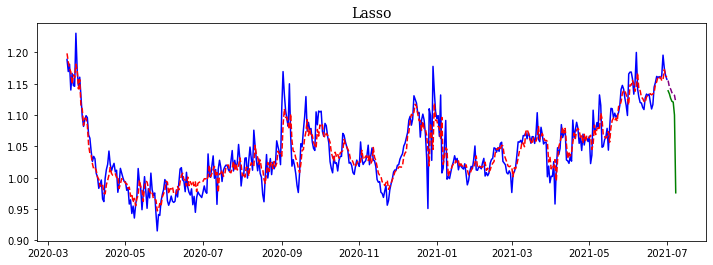

In [8]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = lasso_trained.predict(X_train).clip(0), 
     pred_test = lasso_trained.predict(X_test).clip(0), 
     name = 'Lasso')

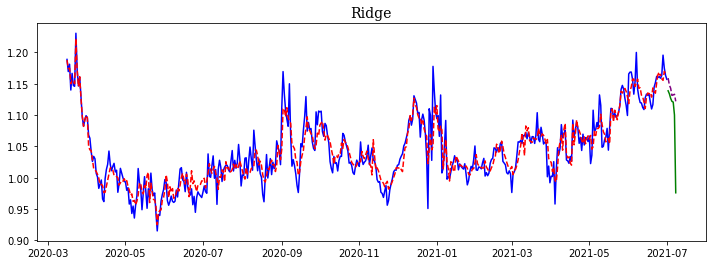

In [9]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = ridge_trained.predict(X_train).clip(0), 
     pred_test = ridge_trained.predict(X_test).clip(0), 
     name = 'Ridge')

# Multi-step Ahead (incremental)

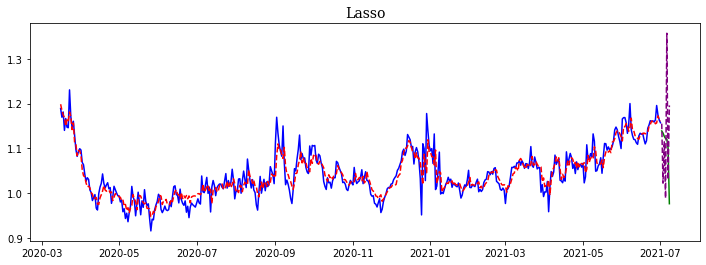

In [10]:
pred_lasso_multistep = multistep_prediction(Xtest=X_test, model=lasso_trained, n_test=7).clip(0)
pred_ridge_multistep = multistep_prediction(Xtest=X_test, model=ridge_trained, n_test=7).clip(0)

plot(train_indx, y_train, test_indx, y_test, 
     pred_train = lasso_trained.predict(X_train).clip(0), 
     pred_test = pred_lasso_multistep, 
     name = 'Lasso')

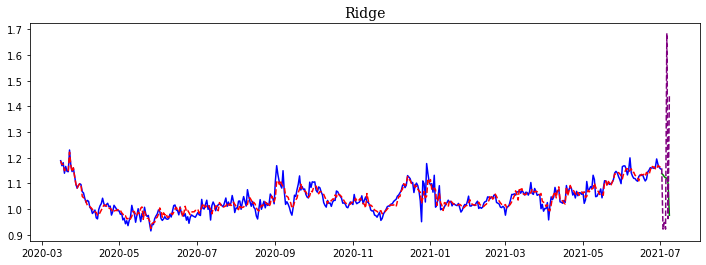

In [11]:
pred_ridge_multistep = multistep_prediction(Xtest=X_test, model=ridge_trained, n_test=7).clip(0)
pred_ridge_multistep = multistep_prediction(Xtest=X_test, model=ridge_trained, n_test=7).clip(0)

plot(train_indx, y_train, test_indx, y_test, 
     pred_train = ridge_trained.predict(X_train).clip(0), 
     pred_test = pred_ridge_multistep, 
     name = 'Ridge')

# Multioutput

In [13]:
X_train_M, X_test_M, y_train_M, y_test_M, train_indx_M, test_indx_M = Create_TrainTest(X = X, 
                                                                                       y = y,
                                                                                       method='multi', 
                                                                                       indx=indx, 
                                                                                       T=10, 
                                                                                       n_test=7)

In [13]:
lasso_multi = train_lasso(X_train_M, y_train_M, 
                          scoring='neg_root_mean_squared_error',
                          random_state=110, 
                          multi_output=True)

pred_lasso_multioutput = lasso_multi.predict(X_test_M)

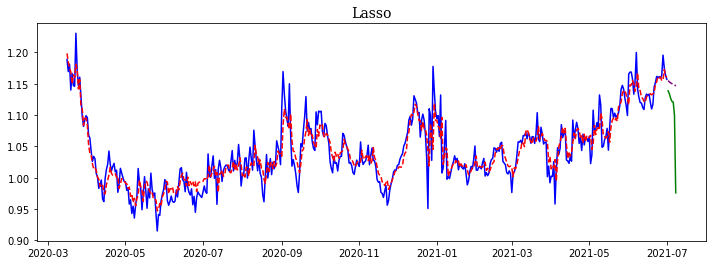

In [14]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = lasso_multi.predict(X_train_M).clip(0)[:,0], 
     pred_test = pred_lasso_multioutput.reshape(-1), 
     name = 'Lasso')

In [15]:
ridge_multi = train_ridge(X_train_M, y_train_M, 
                          scoring='neg_root_mean_squared_error',
                          random_state=110, 
                          multi_output=True)

pred_ridge_multioutput = ridge_multi.predict(X_test_M)

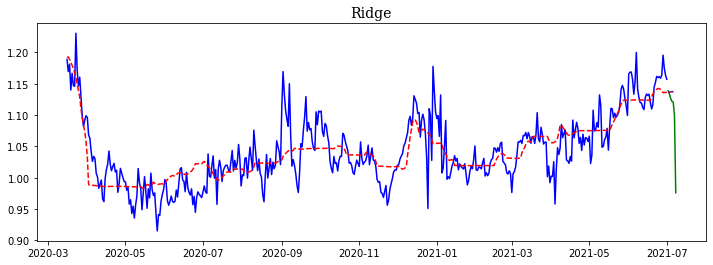

In [16]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = ridge_multi.predict(X_train_M).clip(0)[:,0], 
     pred_test = pred_ridge_multioutput.reshape(-1), 
     name = 'Ridge')

# MLP

In [14]:
from keras.models import Model
from keras.layers import Input, Dense

### 1-step ahead

In [16]:
X_train.shape[1]

100

In [15]:
i = Input(shape=(X_train.shape[1]))
x = Dense(60, activation='relu')(i)
x = Dense(30, activation='relu')(x)
x = Dense(15, activation='relu')(x)
x = Dense(1)(x)
        

mlp = Model(i, x)

In [18]:
mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [19]:
mlp.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
15/15 [==============================] - 0s 18ms/step - loss: 0.3694 - mae: 0.4513 - val_loss: 0.0209 - val_mae: 0.1340
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0404 - mae: 0.1480 - val_loss: 0.0029 - val_mae: 0.0374
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0161 - mae: 0.0883 - val_loss: 0.0579 - val_mae: 0.2346
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0072 - mae: 0.0581 - val_loss: 0.0093 - val_mae: 0.0806
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0051 - mae: 0.0500 - val_loss: 0.0087 - val_mae: 0.0766
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0046 - mae: 0.0482 - val_loss: 0.0062 - val_mae: 0.0586
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0041 - mae: 0.0451 - val_loss: 0.0095 - val_mae: 0.0817
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0037 - mae: 0.0

In [20]:
mlp.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 60)                6060      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 8,371
Trainable params: 8,371
Non-trainable params: 0
_________________________________________________________________


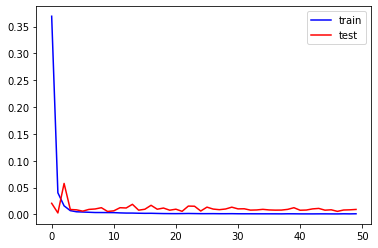

In [21]:
plt.plot(mlp.history.history['loss'], color='blue', label='train')
plt.plot(mlp.history.history['val_loss'], color='red', label='test')

plt.legend()

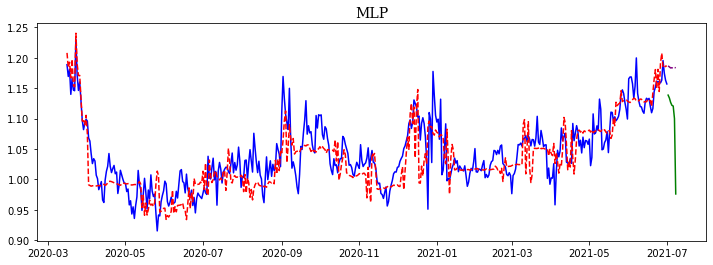

In [22]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = mlp.predict(X_train).clip(0), 
     pred_test = mlp.predict(X_test).clip(0), 
     name = 'MLP')

### 1-step ahead (incremental)

In [23]:
pred_ann_inc = multistep_prediction(Xtest=X_test, model=mlp, n_test=7).clip(0)

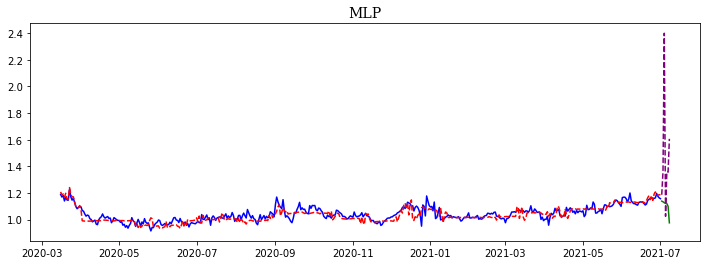

In [24]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = mlp.predict(X_train).clip(0), 
     pred_test = pred_ann_inc, 
     name = 'MLP')

### Multi-output (n_test=7)

In [25]:
N_TEST = 7

i = Input(shape=(X_train.shape[1]))
x = Dense(60, activation='relu')(i)
x = Dense(30, activation='relu')(x)
x = Dense(15, activation='relu')(x)
x = Dense(N_TEST)(x)
        

mlp_multi = Model(i, x)
mlp_multi.compile(optimizer='adam', loss='mse', metrics=['mae'])
mlp_multi.fit(X_train_M, y_train_M, epochs=20, validation_data=(X_test_M, y_test_M))

Epoch 1/20
15/15 [==============================] - 0s 14ms/step - loss: 1.3444 - mae: 0.9404 - val_loss: 0.3098 - val_mae: 0.5037
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 0.2482 - mae: 0.3998 - val_loss: 0.0810 - val_mae: 0.2343
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0856 - mae: 0.2275 - val_loss: 0.0082 - val_mae: 0.0836
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0422 - mae: 0.1558 - val_loss: 0.0108 - val_mae: 0.0827
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0288 - mae: 0.1235 - val_loss: 0.0112 - val_mae: 0.0835
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0226 - mae: 0.1080 - val_loss: 0.0106 - val_mae: 0.0895
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0191 - mae: 0.0994 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 8/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0161 - mae: 0.0

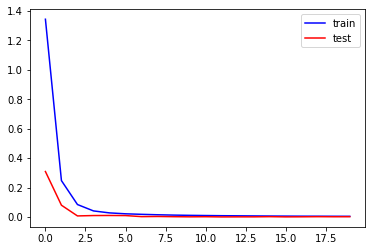

In [26]:
plt.plot(mlp_multi.history.history['loss'], color='blue', label='train')
plt.plot(mlp_multi.history.history['val_loss'], color='red', label='test')

plt.legend()

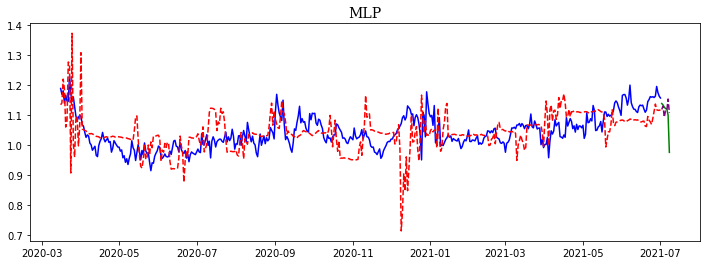

In [27]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = mlp_multi.predict(X_train_M).clip(0)[:,0], 
     pred_test = mlp_multi.predict(X_test_M).reshape(-1), 
     name = 'MLP')